In [1]:
import sys
sys.path.append('../keras')

import pickle
import numpy as np
import pandas as pd
from train import stringify
import seaborn as sns

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def read_results(filename):
    with open(filename, 'rb') as f:
        results = pickle.load(f)
    return results

In [74]:
small_results = read_results('../cross_validation/cw_joint9/9/train.pl')
large_results = read_results('../cross_validation/cw_joint9/ext_8/ext_train.pl')
# old_arch_results = read_results('./cross_validation/old_arch/train.pl')

In [131]:
score_keys = np.array(new_arch_results['score_keys'])
list(score_keys)

['link_categorical_accuracy',
 'link_f1',
 'link_loss',
 'loss',
 'type_categorical_accuracy',
 'type_f1',
 'type_loss',
 'val_link_categorical_accuracy',
 'val_link_f1',
 'val_link_loss',
 'val_loss',
 'val_type_categorical_accuracy',
 'val_type_f1',
 'val_type_loss']

In [147]:
def name_indices(results):
    return list(zip(results['metric_keys'], np.array(results['metrics']).shape))

# Wrong
name_indices(small_results)

[('outer', 1), ('inner', 4), ('param', 7), ('score', 4000)]

In [4]:
small_metrics = np.array(small_results['metrics'])
large_metrics = np.array(large_results['metrics'])

NameError: name 'small_results' is not defined

In [137]:
def list_params(results):
    if isinstance(results, list):
        params = [p for r in results for p in r['params']]
    else:
        params = results['params']
    return [stringify(p) for p in params]

params = list_params([small_results, large_results])

#### Metrics

In [151]:
# get the scores of last epoch or the best.
def get_single_scores(metrics, best=False):
    if best:
        return np.nanmax(metrics,-1)
    return metrics[:,:,:,-1]

def mean_over_cv(metrics, best=False):
    print(metrics.shape)
    return get_single_scores(metrics, best).mean(0).mean(0)

def var_over_cv(metrics, best=False):
    return get_single_scores(metrics, best).mean(0).var(0)

In [152]:
def show_in_df(metrics, score_keys, params):
    return pd.DataFrame(metrics, columns=score_keys, index=params)

In [153]:
metrics = np.concatenate([small_metrics, large_metrics], 1)
metrics.shape

(1, 6, 7, 4000)

In [169]:
show_in_df(mean_over_cv(metrics), score_keys, params).sort_values(['link_f1', 'type_f1'], ascending=False)

(1, 6, 7, 4000)


ValueError: Shape of passed values is (1, 7), indices imply (14, 0)

In [101]:
show_in_df(var_over_cv(metrics), score_keys, params).sort_values(['val_link_f1', 'val_type_f1'])

NameError: name 'metrics' is not defined

### Plots

In [76]:
results['score_keys']

NameError: name 'results' is not defined

In [77]:
metrics.shape

(1, 5, 4, 14, 4000)

In [78]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
def plot_for_params(ps=['val_type_categorical_accuracy', 'val_type_f1']):
    for i, (param, param_metric) in enumerate(zip(params, mean_over_cv(metrics))):
        for score, line in zip(ps, [':','-']):
            ind = list(score_keys).index(score)
            metric = metrics.mean(0).mean(0)[i,ind].T
            metric = np.convolve(metric, np.ones((50,))/50, mode='valid')
            pl, = plt.plot(metric,
                           label='\n'.join([param, score]), 
                           ls=line, 
                           c=pl.get_color() if line == '-' else None)

    plt.legend()

(1, 5, 4, 14, 4000)


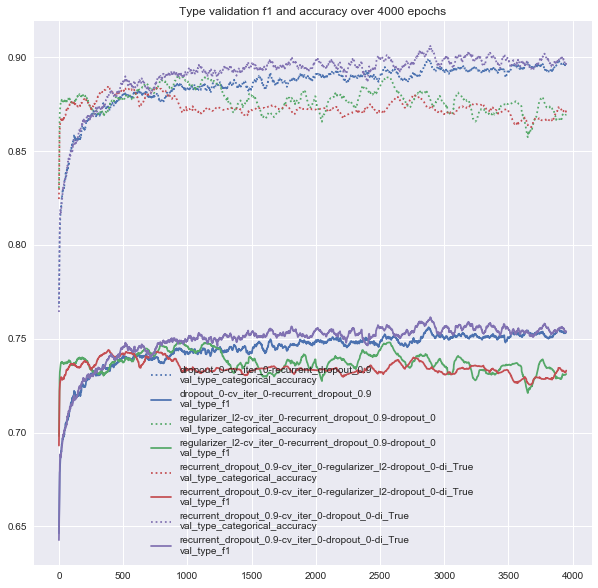

In [80]:
plt.figure(figsize=(10, 10))
plt.title('Type validation f1 and accuracy over 4000 epochs')
plot_for_params(['val_type_categorical_accuracy', 'val_type_f1'])

(1, 5, 4, 14, 4000)


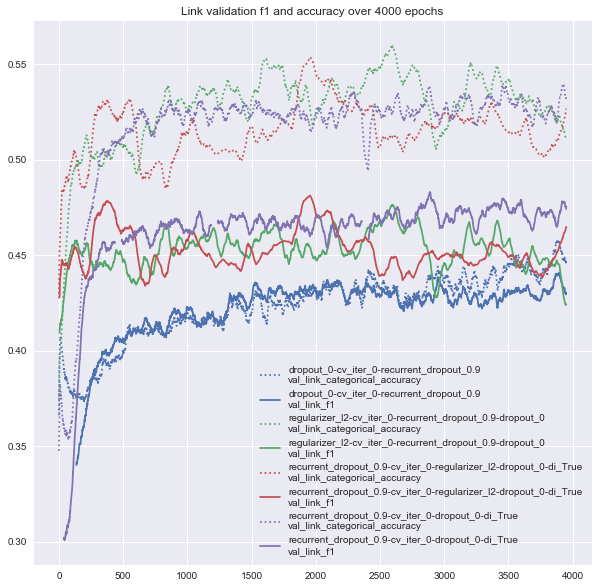

In [81]:
plt.figure(figsize=(10, 10))
plt.title('Link validation f1 and accuracy over 4000 epochs')
plot_for_params(['val_link_categorical_accuracy', 'val_link_f1'])

### Test Results

In [8]:
def average_test(results):
    new = results['tests'].copy()
    for param, v in new.items():
        for metric, v2 in v.items():
            v2 = np.mean(v2)
    return new

In [9]:
import re

def merge_test(results):
    new = {}
    for param, v in results.items():
        param = re.sub(r'cv_iter_\d+-', '', param)
        for metric, v2 in v.items():
            new.setdefault(param, {}).setdefault(metric, []).extend(v2)
                
    return new

In [10]:
pd.DataFrame(merge_test(small_results['tests'])).apply(lambda x: np.mean(np.stack(x), axis=-1))

ValueError: ('all input arrays must have the same shape', 'occurred at index c_weights_False-di_True-joint_False')

In [75]:
# test_results = {param: np.mean(param_res, 0) for param, param_res in cw_joint_results['tests'].items()}
pd.DataFrame(merge_test(large_results['tests'])).applymap(lambda x: np.round(np.mean(x),3))

,c_weights_False-di_True-ext_True-joint_True,c_weights_True-di_True-ext_True-joint_True
links_cat0,0.946,0.938
links_cat1,0.514,0.438
links_macro,0.730,0.688
links_macro_cat,0.244,0.258
links_weighted,0.903,0.888
types_cat0,0.929,0.903
types_cat1,0.716,0.672
types_macro,0.822,0.787
types_macro_cat,0.822,0.787
types_weighted,0.888,0.859


In [76]:
pd.DataFrame(merge_test(small_results['tests'])).applymap(lambda x: np.round(np.mean(x),3))

,c_weights_False-di_True-joint_False,c_weights_False-di_True-joint_True,c_weights_True-di_True-joint_True
links_cat0,0.953,0.951,0.949
links_cat1,0.576,0.556,0.538
links_macro,0.765,0.753,0.744
links_macro_cat,0.382,0.370,0.391
links_weighted,0.915,0.911,0.908
types_cat0,NaN,0.938,0.908
types_cat1,NaN,0.725,0.703
types_macro,NaN,0.831,0.805
types_macro_cat,NaN,0.831,0.805
types_weighted,NaN,0.896,0.868


In [27]:
?? np.stack

In [37]:
merge_test(small_results['tests'])['c_weights_False-di_True-joint_False']

{'links_cat0': [0.9444444444444444,
  0.9587813620071685,
  0.9472693032015066,
  0.9351851851851852,
  0.966903073286052,
  0.9537037037037037],
 'links_cat1': [0.5,
  0.6290322580645161,
  0.5254237288135594,
  0.4166666666666667,
  0.7021276595744681,
  0.5833333333333334],
 'links_macro': [0.7222222222222222,
  0.7939068100358423,
  0.736346516007533,
  0.6759259259259259,
  0.83451536643026,
  0.7685185185185186],
 'links_macro_cat': [0.3413683422086783,
  0.5516597867217062,
  0.423015873015873,
  0.17764378478664195,
  0.3320574162679426,
  0.3711111111111111],
 'links_weighted': [0.9,
  0.9258064516129032,
  0.9050847457627119,
  0.8833333333333333,
  0.9404255319148936,
  0.9166666666666666]}